In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!git clone https://github.com/IT22052124/SE4050-Deep-Learning-Assignment

Cloning into 'SE4050-Deep-Learning-Assignment'...
remote: Enumerating objects: 3336, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 3336 (delta 119), reused 195 (delta 59), pack-reused 3058 (from 2)
Receiving objects: 100% (3336/3336), 63.14 MiB | 23.90 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [8]:
%cd SE4050-Deep-Learning-Assignment

/content/SE4050-Deep-Learning-Assignment


In [9]:
!pip install tensorflow keras matplotlib scikit-learn opencv-python kagglehub

In [10]:
import kagglehub

path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")
print("✅ Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-detection' dataset.
✅ Path to dataset files: /kaggle/input/brain-tumor-detection


In [12]:
import os, shutil

DATASET_SRC = path + "/Brain Tumor Classification Data Set"
DATASET_DIR = "/kaggle/input/brain-tumor-detection"
if not os.path.exists(DATASET_DIR):
    shutil.copytree(DATASET_SRC, DATASET_DIR)
print("✅ Dataset ready at:", DATASET_DIR)

✅ Dataset ready at: /kaggle/input/brain-tumor-detection


In [13]:
import os
import random
from shutil import copy2
from sklearn.model_selection import train_test_split

SRC_DIR = DATASET_DIR
DEST_DIR = "/content/Brain_Tumor_Dataset_Split"
os.makedirs(DEST_DIR, exist_ok=True)

classes = ['yes', 'no']
splits = ['train', 'val', 'test']
ratios = [0.7, 0.15, 0.15]  # 70/15/15 split

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(DEST_DIR, split, cls), exist_ok=True)

for cls in classes:
    files = os.listdir(os.path.join(SRC_DIR, cls))
    random.shuffle(files)

    train_files, temp = train_test_split(files, test_size=(1-ratios[0]), random_state=42)
    val_files, test_files = train_test_split(temp, test_size=0.5, random_state=42)

    for f in train_files:
        copy2(os.path.join(SRC_DIR, cls, f), os.path.join(DEST_DIR, 'train', cls))
    for f in val_files:
        copy2(os.path.join(SRC_DIR, cls, f), os.path.join(DEST_DIR, 'val', cls))
    for f in test_files:
        copy2(os.path.join(SRC_DIR, cls, f), os.path.join(DEST_DIR, 'test', cls))

print("✅ Dataset split complete")


✅ Dataset split complete


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DEST_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(DEST_DIR, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(DEST_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)


Found 2098 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 452 images belonging to 2 classes.


In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers

def build_efficientnetb0(input_shape=(224,224,3)):
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_efficientnetb0()
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

RESULTS_DIR = "/content/efficientnetb0_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

checkpoint = ModelCheckpoint(os.path.join(RESULTS_DIR, "best_model.keras"),
                             monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, earlystop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.4775 - loss: 0.7068 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - accuracy: 0.4931 - loss: 0.7015 - val_accuracy: 0.4889 - val_loss: 0.6931
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.4814 - loss: 0.7024 - val_accuracy: 0.4978 - val_loss: 0.6931
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.5256 - loss: 0.6915 - val_accuracy: 0.5044 - val_loss: 0.6932
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.4885 - loss: 0.7024 - val_accuracy: 0.5333 - val_loss: 0.6929
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.5024 - loss: 0.6973 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.4910 - loss: 0.7020 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.4894 - loss: 0.7026 - val_accuracy: 0.5000 - v

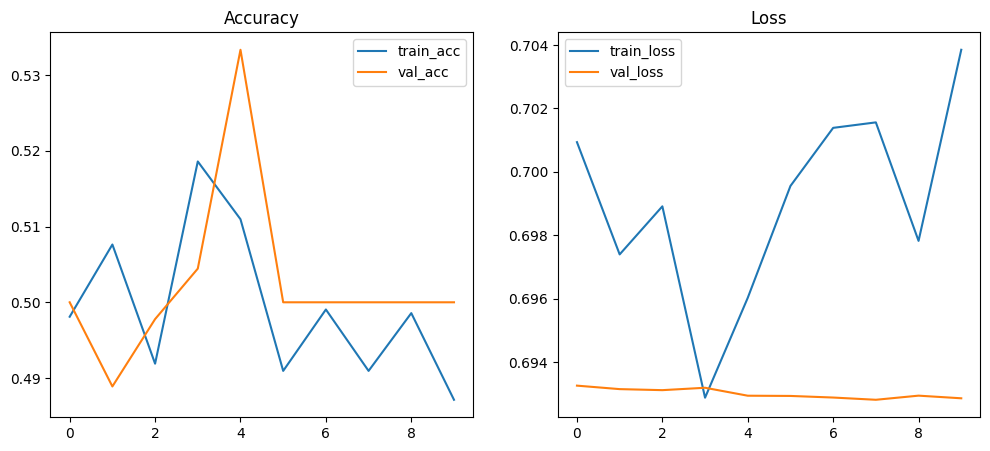

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()


452/452 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step
✅ Accuracy: 0.5110619469026548

Classification Report:
               precision    recall  f1-score   support

          no       0.51      0.92      0.65       226
         yes       0.56      0.10      0.17       226

    accuracy                           0.51       452
   macro avg       0.53      0.51      0.41       452
weighted avg       0.53      0.51      0.41       452



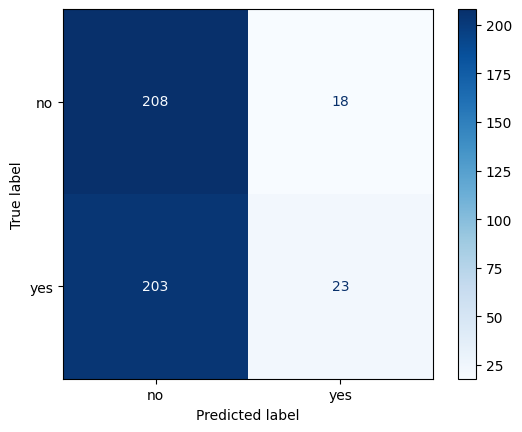

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

model.load_weights(os.path.join(RESULTS_DIR, "best_model.keras"))

test_gen.reset()
preds = model.predict(test_gen, verbose=1)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = test_gen.classes

print("✅ Accuracy:", np.mean(y_pred == y_true))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['no', 'yes']))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['no', 'yes']).plot(cmap='Blues')
plt.show()
